### Preprocessing

In [1]:
import pandas as pd

In [2]:
df = pd.read_table('data/pdbbind/index/INDEX_general_PL_data.2020',skiprows=4,sep=r'\s+',usecols=[0,4]).drop(0)
df = df.rename(columns={'#': 'name','release': 'affinity'})
df_refined = pd.read_table('data/pdbbind/index/INDEX_refined_data.2020',skiprows=4,sep=r'\s+',usecols=[0,4]).drop(0)
df_refined = df_refined.rename(columns={'#': 'name','release': 'affinity'})
df = pd.concat([df,df_refined])

In [3]:
quantities = ['ki','kd','ka','k1/2','kb','ic50','ec50']

In [4]:
from pint import UnitRegistry
ureg = UnitRegistry()

def to_uM(affinity):
    val = ureg(affinity)
    try:
        return val.m_as(ureg.uM)
    except Exception:
        pass
    
    try:
        return 1/val.m_as(1/ureg.uM)
    except Exception:
        pass

In [5]:
df['affinity_uM'] = df['affinity'].str.split('[=\~><]').str[1].apply(to_uM)
df['affinity_quantity'] = df['affinity'].str.split('[=\~><]').str[0]

<AxesSubplot:>

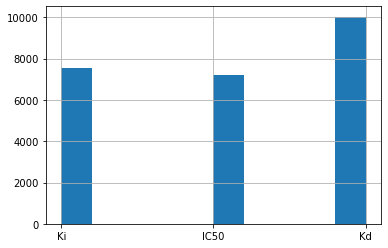

In [6]:
df['affinity_quantity'].hist()

In [7]:
df_filter = df[df['affinity_quantity'].str.lower().isin(quantities)]
df_filter = df_filter.dropna()

In [8]:
df_complex = pd.read_parquet('data/pdbbind_complex.parquet')

In [9]:
import dask.array as da
import dask.dataframe as dd
from dask.bag import from_delayed
from dask import delayed
import pyarrow as pa
import pyarrow.parquet as pq

In [10]:
contacts_dask = da.from_npy_stack('data/pdbbind_contacts')
contacts_dask = contacts_dask.reshape(-1,contacts_dask.shape[-2]*contacts_dask.shape[-1])

In [11]:
df_complex.head()

name                                                seq  \
0  2lbv  MTVPDRSEIAGKWYVVALASNTEFFLREKDKMKMAMARISFLGEDE...   
1  1lt6  APQTITELCSEYRNTQIYTINDKILSYTESMAGKREMVIITFKSGE...   
2  4lwi  VETFAFQAEIAQLMSLIINTFYSNKEIFLRELISNSSDALDKIRYE...   
3  6oyz  VQLQESGGGLVQTGGSLTLSCATSGRSFSLYAMAWFRQAPGKEREF...   
4  4i11  GSFVEMVDNLRGKSGQGYYVEMTVGSPPQTLNILVDTGSSNFAVGA...   

                                              smiles  
0                          CCCCCCCCCCCCCCCCCCCC(=O)O  
1         O=[N+]([O-])c1cccc(OC2OC(CO)C(O)C(O)C2O)c1  
2  COc1ccc(-c2c(-c3cc(C(C)C)c(O)cc3O)noc2NC(=O)C2...  
3  COC1C(O)C(n2ccc(=O)[nH]c2=O)OC1C(OC1OC(C(=O)NC...  
4           CC1(C)Cc2ccccc2C(NC(Cc2ccccc2)C(=O)O)=N1

In [12]:
contacts_dask.blocks[1]

dask.array<blocks, shape=(438, 1043460), dtype=float32, chunksize=(438, 1043460), chunktype=numpy.ndarray>

In [19]:
import numpy as np
def chunk_to_sparse(chunk, idx_chunk):
    res = df_complex.iloc[idx_chunk].copy()
    # pad to account for [CLS] and [SEP]
    res['contacts'] = [np.where(np.pad(a,pad_width=(1,1)))[0] for a in chunk]
    return res

partitions = [delayed(chunk_to_sparse)(b,k)
              for b,k in zip(contacts_dask.blocks, da.arange(contacts_dask.shape[0],chunks=contacts_dask.chunks[0:1]).blocks)
             ]

In [20]:
partitions[0].compute().head()

name                                                seq  \
0  2lbv  MTVPDRSEIAGKWYVVALASNTEFFLREKDKMKMAMARISFLGEDE...   
1  1lt6  APQTITELCSEYRNTQIYTINDKILSYTESMAGKREMVIITFKSGE...   
2  4lwi  VETFAFQAEIAQLMSLIINTFYSNKEIFLRELISNSSDALDKIRYE...   
3  6oyz  VQLQESGGGLVQTGGSLTLSCATSGRSFSLYAMAWFRQAPGKEREF...   
4  4i11  GSFVEMVDNLRGKSGQGYYVEMTVGSPPQTLNILVDTGSSNFAVGA...   

                                              smiles  \
0                          CCCCCCCCCCCCCCCCCCCC(=O)O   
1         O=[N+]([O-])c1cccc(OC2OC(CO)C(O)C(O)C2O)c1   
2  COc1ccc(-c2c(-c3cc(C(C)C)c(O)cc3O)noc2NC(=O)C2...   
3  COC1C(O)C(n2ccc(=O)[nH]c2=O)OC1C(OC1OC(C(=O)NC...   
4           CC1(C)Cc2ccccc2C(NC(Cc2ccccc2)C(=O)O)=N1   

                                            contacts  
0  [1043, 2569, 2570, 2573, 2575, 6121, 6122, 612...  
1  [513, 517, 519, 520, 521, 522, 524, 525, 545, ...  
2  [520, 522, 525, 541, 543, 545, 546, 547, 1038,...  
3  [35195, 35197, 35199, 35201, 35205, 35210, 352...  
4  [36231, 36232, 36234, 36235, 36236, 36237, 362...

In [21]:
ddf = dd.from_delayed(partitions)

In [22]:
ddf_all = ddf.merge(df_filter, on='name').drop(columns=['affinity'])

In [23]:
%%time
df_all_contacts = ddf_all.compute()

CPU times: user 2min 8s, sys: 3min 26s, total: 5min 35s
Wall time: 2min 12s


In [24]:
df_all_contacts['neg_log10_affinity_M'] = 6-np.log10(df_all_contacts['affinity_uM'])

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_all_contacts['affinity'] = scaler.fit_transform(df_all_contacts['neg_log10_affinity_M'].values.reshape(-1,1))
scaler.mean_, scaler.var_

(array([6.3455065]), array([3.57430038]))

In [26]:
# save to parquet
df_all_contacts.drop(columns=['name','affinity_quantity']).astype({'affinity': 'float32','neg_log10_affinity_M': 'float32'}).to_parquet('data/pdbbind_with_contacts.parquet',index=False)

In [127]:
df_all = df_complex.merge(df_filter,on='name').drop('affinity',axis=1)

In [128]:
df_all

name                                                seq  \
0      2lbv  MTVPDRSEIAGKWYVVALASNTEFFLREKDKMKMAMARISFLGEDE...   
1      1lt6  APQTITELCSEYRNTQIYTINDKILSYTESMAGKREMVIITFKSGE...   
2      4lwi  VETFAFQAEIAQLMSLIINTFYSNKEIFLRELISNSSDALDKIRYE...   
3      6oyz  VQLQESGGGLVQTGGSLTLSCATSGRSFSLYAMAWFRQAPGKEREF...   
4      4i11  GSFVEMVDNLRGKSGQGYYVEMTVGSPPQTLNILVDTGSSNFAVGA...   
...     ...                                                ...   
20822  2bok  IVGGQECKDGECPWQALLINEENEGFCGGTILSEFYILTAAHCLYQ...   
20823  4j46  GTIYPRNPAMYSEEARLKSFQNWPDYAHLTPRELASAGLYYTGIGD...   
20824  4j46  GTIYPRNPAMYSEEARLKSFQNWPDYAHLTPRELASAGLYYTGIGD...   
20825  2c80  DHIKVIYFNGRGRAESIRMTLVAAGVNYEDERISFQDWPKIKPTIP...   
20826  2c80  DHIKVIYFNGRGRAESIRMTLVAAGVNYEDERISFQDWPKIKPTIP...   

                                                  smiles  affinity_uM  \
0                              CCCCCCCCCCCCCCCCCCCC(=O)O        0.026   
1             O=[N+]([O-])c1cccc(OC2OC(CO)C(O)C(O)C2O)c1      500.000   
2      COc1ccc(-c2c(-c3cc(C(C)C)c(O)cc3O)noc2NC(=O)C2...        0.023   
3      COC1C(O)C(n2ccc(=O)[nH]c2=O)OC1C(OC1OC(C(=O)NC...        0.185   
4               CC1(C)Cc2ccccc2C(NC(Cc2ccccc2)C(=O)O)=N1       27.200   
...                                                  ...          ...   
20822  C[N+](C)(C)CCCN1C(=O)C2C(C1=O)C(c1ccc(C(=N)N)c...        0.280   
20823  CCC(C)C(NC(=O)C1CCCN1C(=O)C(NC(=O)C(C)[NH3+])C...        5.240   
20824  CCC(C)C(NC(=O)C1CCCN1C(=O)C(NC(=O)C(C)[NH3+])C...        5.240   
20825    CCCCCCSCC(NC(=O)CCC([NH3+])C(=O)O)C(=O)NCC(=O)O        4.700   
20826    CCCCCCSCC(NC(=O)CCC([NH3+])C(=O)O)C(=O)NCC(=O)O        4.700   

      affinity_quantity  
0                    Kd  
1                  IC50  
2                  IC50  
3                  IC50  
4                  IC50  
...                 ...  
20822                Ki  
20823                Ki  
20824                Ki  
20825                Kd  
20826                Kd  

[20827 rows x 5 columns]

In [14]:
df_all.to_parquet('data/pdbbind.parquet')